In [7]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *                                                                                                                                                                                                                                           

In [8]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Overfitting

When we have many features available to include in a model, choosing which ones to include or exclude rapidly gets complicated. In the upward mobility from {numref}`Chapter %s <ch:linear>` we chose two of the seven variables to fit the model, but there are 21 pairs of features that we could have examined and fitted for a two-variable model.
And, there are over 100 models to choose from, if we consider all one-, two-, ..., seven-variable models.
It can be hard to to examine hundreds of residual plots, to decide how simple is simple, and settle on a model. 
Unfortunately, the notion of minimizing MSE isn't entirely helpful either. With each variable that we add to a model, the MSE typically gets smaller. Recall from the geometric perspective of model fitting ({numref}`Chapter %s <ch:linear>`) that adding a feature to a model adds an $n$-dimensional vector to the feature space, and the error between the outcome vector and its projection into the space spanned by the explanatory variables shrinks. We might view this as a good thing because our model fits the data more closely, but there is a danger in overfitting. 

Overfitting happens when the model follows the data too closely and picks up the variability in the random noise in the outcome. When this happens, new observations are not well predicted. An example, helps clarify this idea.

## Example: Energy Consumption 

The following dataset contains the utility bills from a private residence in Minnesota. We have records of the monthly gas usage in a home (cubic feet) and the average temperature that month (degrees Farenheit)[^Kaplan].

[^Kaplan]: These data are from Daniel T. Kaplan, Statistical modeling: A fresh approach, 2009. https://www.key2stats.com/Utility_bills_1294_92.csv

In [9]:
heat_df = pd.read_csv('data/utilities.csv', usecols = ['temp','ccf'])
heat_df

,temp,ccf
0,29,166
1,31,179
2,15,224
...,...,...
96,76,11
97,55,32
98,39,91


Let's begin by looking at a scatter plot of gas consumption as a function of temperature. 

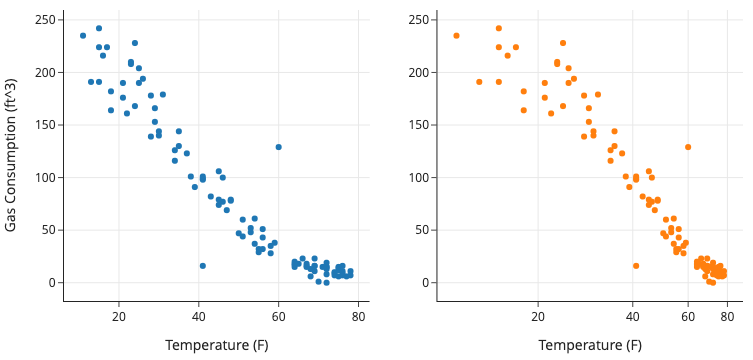

In [10]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=heat_df['temp'], y=heat_df['ccf'], mode="markers"),
    row=1, col=1)

fig.update_xaxes(title='Temperature (F)', row=1, col=1)
fig.update_yaxes(title='Gas Consumption (ft^3)', row=1, col=1)

fig.add_trace(
    go.Scatter(x=heat_df['temp'], y=heat_df['ccf'], mode="markers"),
    row=1, col=2)

fig.update_xaxes(type="log", title='Temperature (F)', row=1, col=2)

fig.update_layout(height=250, width=500, showlegend=False)
fig.show()

The relationship shows curvature, but when we tried to straighten it with a log transformation a different curvature arises. Additionally, there are two unusual points. When we refer back to the documentation, we find that these points represent recording errors, so we remove them.  

In [11]:
heat_df = heat_df.loc[~(((heat_df['temp'] == 60) & (heat_df['ccf']==129)) | 
                        ((heat_df['temp'] == 41) & (heat_df['ccf']==16))), :]

Let's see if a quadratic curve can capture the relationship between gas usage and temperature. 
Polynomials are still considered linear models. They are linear in their polynomial features. For example, we can express a quadratic model as,

$$
\theta_0 + \theta_1 x + \theta_2 x^2
$$

This model is linear in the features $x$ and $x^2$, and in matrix notation we can write this model as ${\textbf{X}} {\boldsymbol{\theta}}$, where
$ \textbf{X} $ is the design matrix,

$$
\left\lceil
\begin{matrix}
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
\vdots & \vdots & \vdots\\
1 & x_n & x_n^2\\
\end{matrix}
\right\rceil
$$

We can create the polynomial features of the design matrix with the `PolynomialFeatures` tool in `scikit-learn`. 

In [12]:
y = heat_df['ccf']
X = heat_df[['temp']]

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
poly_features

array([[  29.,  841.],
       [  31.,  961.],
       [  15.,  225.],
       ...,
       [  76., 5776.],
       [  55., 3025.],
       [  39., 1521.]])

We set the parameter `include_bias` to `False` because we plan to fit the polynomial with the `LinearRegression` method in `scikit-learn`, and by default it includes the constant term in the model. 

In [13]:
from sklearn.linear_model import LinearRegression

model_deg2 = LinearRegression().fit(poly_features, y)

We overlay the fitted quadratic on the scatter plot and examine the residuals to get a quick idea as to the quality of the fit.

In [14]:
def make_ys(mod, deg, xs):    
    poly_x = PolynomialFeatures(degree=deg, include_bias=False)
    poly_features_x = poly_x.fit_transform(xs.reshape(-1, 1))
    ys = mod.predict(poly_features_x)
    return ys.flatten()

In [15]:
y_hat = model_deg2.predict(poly_features)
model_fit = pd.DataFrame(data=y_hat, columns=['y_hat'])
model_fit['err'] = y-y_hat

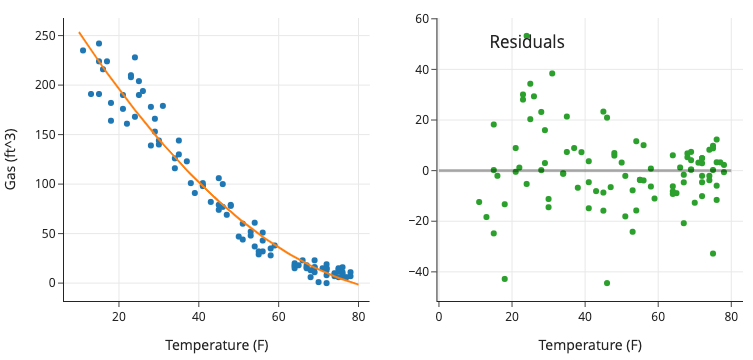

In [16]:
xs = np.linspace(10, 80, num=71)
ys_deg2 = make_ys(mod = model_deg2, deg=2, xs=xs)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=heat_df['temp'], y=heat_df['ccf'],
              mode="markers"),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=ys_deg2), 
    row=1, col=1)
fig.update_xaxes(title='Temperature (F)', row=1, col=1)
fig.update_yaxes(title='Gas (ft^3)', row=1, col=1)


fig.add_trace(
    go.Scatter(x=heat_df['temp'], y=model_fit['err'],
              mode="markers"),
    row=1, col=2)

fig.add_shape(type="line",
    x0=0, y0=0, x1=80, y1=0,
    line=dict(
        color="Black", width=3),
    row=1, col=2)

fig.update_xaxes(title='Temperature (F)', row=1, col=2)

fig.update_layout(height=250, width=550, showlegend=False,
                 title={
        'text': "Residuals",
        'y':0.9,
        'x':0.75,
        'xanchor': 'right',
        'yanchor': 'top'})

fig.show()

The quadratic captures the curve in the data quite well, but the residuals show a slight upward trend in the 70-80 degree range of temperature, which indicates some lack of fit. There is also some funneling in the residuals, where the variability in gas consumption is greater in the colder months. We might expect this behavior since we have only the monthly average temperature. 

For comparison, we fit a few more models with higher degree polynomials and collectively examine the fitted curves. 

In [17]:
poly12 = PolynomialFeatures(degree=12, include_bias=False)
poly_features12 = poly12.fit_transform(X)

degrees = [1, 2, 3, 6, 8, 12]

mods = [LinearRegression().fit(poly_features12[ :, :deg], y)
        for deg in degrees]

:::{warning}

Fitting polynomials in this way is not advisable. We have used this traditional  form of polynomials to focus on the notion of over fitting. 

Unfortunately, these polynomial features tend to be highly correlated. For example, the correlation between $x$ and $x^2$ for the energy data is 0.98. Highly correlated features give unstable coefficients, where a small change in an x-value can lead to a large change in the coefficients of the polynomial. 
Also, when the $x$ values are large, then the normal equations are poorly conditioned and the coefficients can be difficult to interpret and compare.  

A better practice is to use polynomials that have been constructed to be orthogonal to one another. These polynomials fill the same space as the original polynomials, but they are uncorrelated with one another and give a more stable fit. 

:::

The plot below places all of the fits on the same graph so that we can see how the higher degree polynomials bend more and more strangely. 

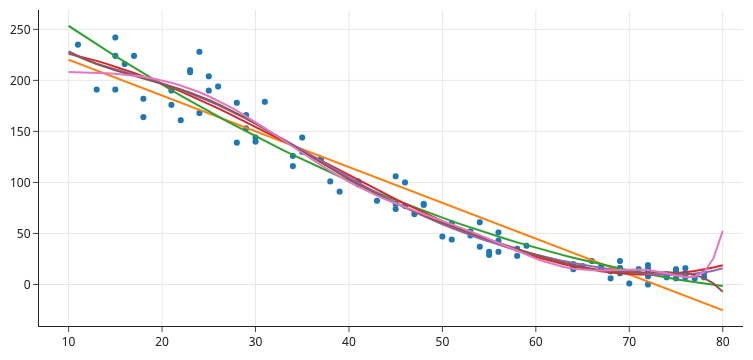

In [31]:
ys = [make_ys(mod = mods[j], deg = degrees[j], xs = xs)
      for j in range(6)]

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"))

fig.add_trace(
    go.Scatter(x=xs, y=ys[0]))

fig.add_trace(
    go.Scatter(x=xs, y=ys[1]))

fig.add_trace(
    go.Scatter(x=xs, y=ys[2]))

fig.add_trace(
    go.Scatter(x=xs, y=ys[3]))

fig.add_trace(
    go.Scatter(x=xs, y=ys[4]))

fig.add_trace(
    go.Scatter(x=xs, y=ys[5]))


fig.update_layout(height=250, width=500, showlegend=False)
fig.show()

We can also visualize the different polynomial fits in separate facets. 

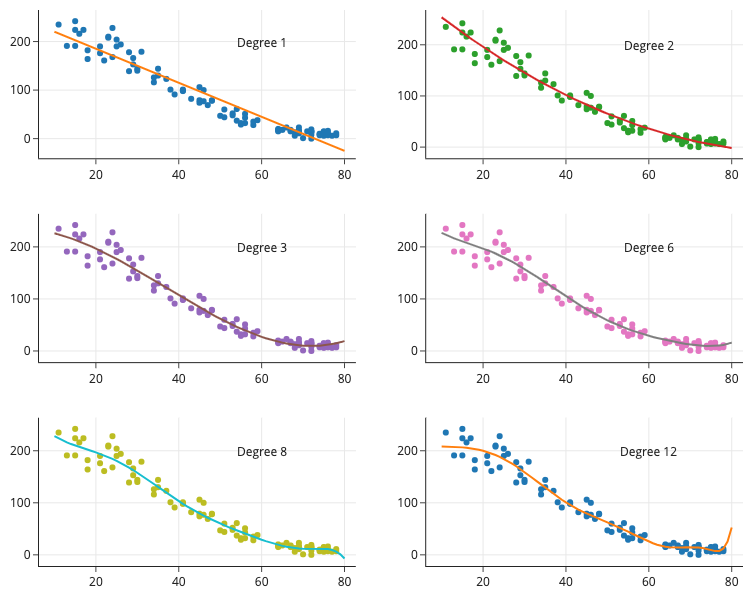

In [32]:
ys = [make_ys(mod = mods[j], deg = degrees[j], xs = xs)
      for j in range(6)]

fig = make_subplots(rows=3, cols=2)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=ys[0]), 
    row=1, col=1)

fig.add_annotation(x=60, y=200,
            text="Degree 1", showarrow=False,
            row=1, col=1)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=xs, y=ys[1]), 
    row=1, col=2)

fig.add_annotation(x=60, y=200,
            text="Degree 2", showarrow=False,
            row=1, col=2)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=2, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=ys[2]), 
    row=2, col=1)

fig.add_annotation(x=60, y=200,
            text="Degree 3", showarrow=False,
            row=2, col=1)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=2, col=2)

fig.add_trace(
    go.Scatter(x=xs, y=ys[3]), 
    row=2, col=2)

fig.add_annotation(x=60, y=200,
            text="Degree 6", showarrow=False,
            row=2, col=2)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=3, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=ys[4]), 
    row=3, col=1)

fig.add_annotation(x=60, y=200,
            text="Degree 8", showarrow=False,
            row=3, col=1)

fig.add_trace(
    go.Scatter(x=X['temp'], y=y,
              mode="markers"),
    row=3, col=2)

fig.add_trace(
    go.Scatter(x=xs, y=ys[5]), 
    row=3, col=2)

fig.add_annotation(x=60, y=200,
            text="Degree 12", showarrow=False,
            row=3, col=2)


fig.update_layout(height=600, width=500, showlegend=False)
fig.show()

The degree 1 curve (the straight line) in the top left facet misses the curved pattern in the data. The degree 2, begins to capture it, and the degree 3 looks like an improvement but notice the upward bend at the right side of the plot. The polynomials of degree 6, 8, and 12 follow the data more and more closely, as they get more and more curvy. These polynomials seem to fit spurious bumps in the data. All together, these six curves illustrate under- and over- fitting. The fitted line in the top left under-fits and misses the curvature entirely. And, the degree 12 polynomial in the bottom right definitely over-fits with a wiggly pattern that we don't think makes sense in this context. 

In general, as we add more features, models get more complex and the MSE drops, but at the same time, 
the fitted model grows increasingly erratic and sensitive to the data.
When we over-fit, the model follows the data too closely, and predictions are poor for new observations. One simple technique to assess a fitted model is it compute the MSE on new data, data that were not used in building the model. Since we don't typically have the capacity to acquire more data, we set aside some of the original data to evaluate the fitted model. This technique is the topic of the next section.  